# **1. 모델 설계**

In [13]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [14]:
!kaggle datasets download -d dansbecker/cityscapes-image-pairs

Dataset URL: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs
License(s): other
cityscapes-image-pairs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
!unzip -o /root/week3/cityscapes-image-pairs.zip -d /root/week3/cityscapes

Archive:  /root/week3/cityscapes-image-pairs.zip
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/1.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/10.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/100.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/1000.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/1001.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/1002.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/1003.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/1004.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/1005.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/1006.jpg  
  inflating: /root/week3/cityscapes/cityscapes_data/cityscapes_data/train/1007.jpg  
  inflating: /root/wee

데이터 다운: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

In [16]:
import os

root_path = '/root/week3/cityscapes/cityscapes_data'

data_dir = root_path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


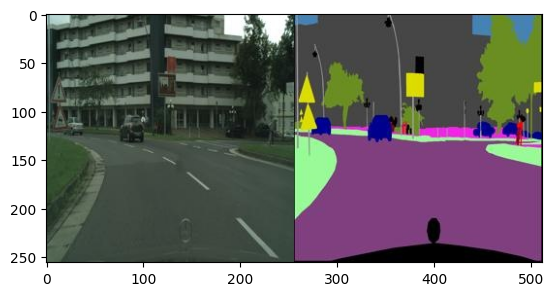

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [18]:
import numpy as np
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [19]:
from sklearn.cluster import KMeans
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [20]:
def split_image(image) :
   image = np.array(image)
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label

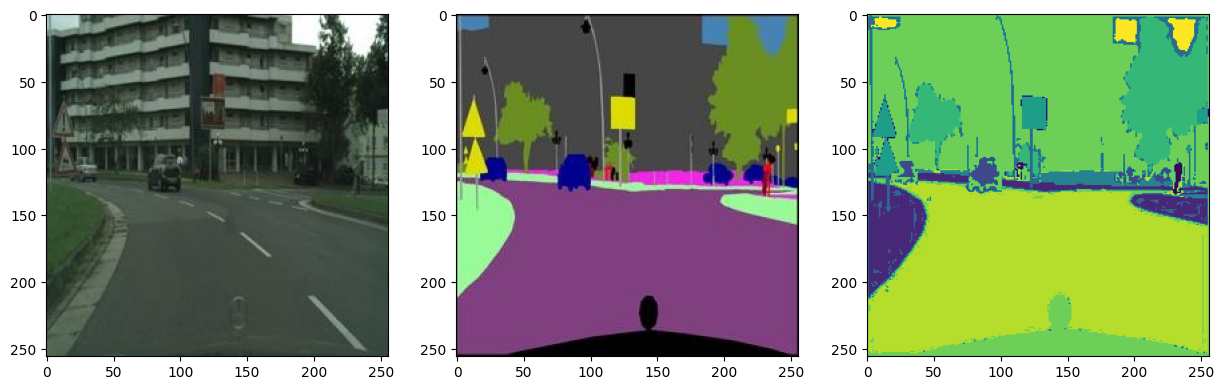

In [21]:
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [22]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self) :
    return len(self.image_fns)

  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label

  def transform(self, image) :
    transform_ops = transforms.Compose([
      			transforms.ToTensor(),
                        transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

2975
torch.Size([3, 256, 256])
torch.Size([256, 256])


In [23]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        # Encoder
        self.encoder_block1 = self.conv_block(3, 64)
        self.maxpool_1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.encoder_block2 = self.conv_block(64, 128)
        self.maxpool_2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.encoder_block3 = self.conv_block(128, 256)
        self.maxpool_3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.encoder_block4 = self.conv_block(256, 512)
        self.maxpool_4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.encoder_block5 = self.conv_block(512, 1024)
        
        # Decoder
        self.transpose_conv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_block1 = self.conv_block(1024, 512)
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_block2 = self.conv_block(512, 256)
        self.transpose_conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_block3 = self.conv_block(256, 128)
        self.transpose_conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_block4 = self.conv_block(128, 64)

        self.output = nn.Conv2d(64, num_classes, kernel_size = 1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        )

    def forward(self, X):
        # Encoder
        encoder_output1 = self.encoder_block1(X)
        encoder_output2 = self.encoder_block2(self.maxpool_1(encoder_output1))
        encoder_output3 = self.encoder_block3(self.maxpool_2(encoder_output2))
        encoder_output4 = self.encoder_block4(self.maxpool_3(encoder_output3))
        encoder_output5 = self.encoder_block5(self.maxpool_4(encoder_output4))
        
        # Decoder
        x = self.decoder_block1(torch.cat([self.transpose_conv1(encoder_output5), encoder_output4], 1))
        x = self.decoder_block2(torch.cat([self.transpose_conv2(x), encoder_output3], 1))
        x = self.decoder_block3(torch.cat([self.transpose_conv3(x), encoder_output2], 1))
        x = self.decoder_block4(torch.cat([self.transpose_conv4(x), encoder_output1], 1))

        output_out = self.output(x)
        return output_out

In [24]:
# clear the cache of cuda
torch.cuda.empty_cache()

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model = UNet(num_classes=num_classes)
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape)
print(Y.shape)

2975 744
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [26]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


# **2. 모델 학습**

In [31]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 하이퍼파라미터 자율설정

batch_size = 50

epochs = 100
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = UNet(num_classes = num_classes).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)) :
  epoch_loss = 0

  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [2:44:57<00:00, 98.98s/it]  


In [32]:
print(len(epoch_losses))
print(epoch_losses)

100
[1.1917519321044285, 0.9587085982163747, 0.8776412675778071, 0.846324094136556, 0.825011353691419, 0.8050524751345317, 0.7829831073681514, 0.7571683039267858, 0.7394465704758962, 0.7250800897677739, 0.7093872100114822, 0.6878350347280502, 0.6708276549975077, 0.658870667219162, 0.6427911301453908, 0.629835499326388, 0.6190611019730567, 0.6043274144331614, 0.5981010725100835, 0.5890845442811649, 0.5809841960668564, 0.5721402660012245, 0.5632071206967036, 0.5474030370513598, 0.5342464650670687, 0.5211381390690804, 0.509397043287754, 0.49941485077142717, 0.49173433234294256, 0.4940512453516324, 0.4861736983060837, 0.4747410908341408, 0.4638739873965581, 0.4577520102262497, 0.44703797698020936, 0.43533276865879694, 0.4296650062004725, 0.42805059601863227, 0.4199465940395991, 0.4053566291928291, 0.39356058835983276, 0.38745150764783226, 0.37981679340203606, 0.37793928931156795, 0.37053405940532685, 0.36229559828837715, 0.3600947727759679, 0.34872520466645557, 0.3419825300574303, 0.339209

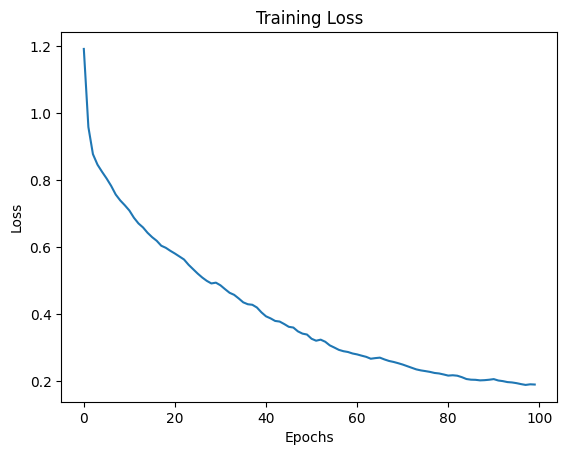

In [33]:
##TODO
plt.plot(epoch_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [34]:
model_name = "UNet.pth"
torch.save(model.state_dict(), root_path + model_name)

# **3. 모델 평가**

In [35]:
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [36]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.096156806..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10399997..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10399997..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10399997..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.096156806..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10399997..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10007839..1.0].
Clipping input dat

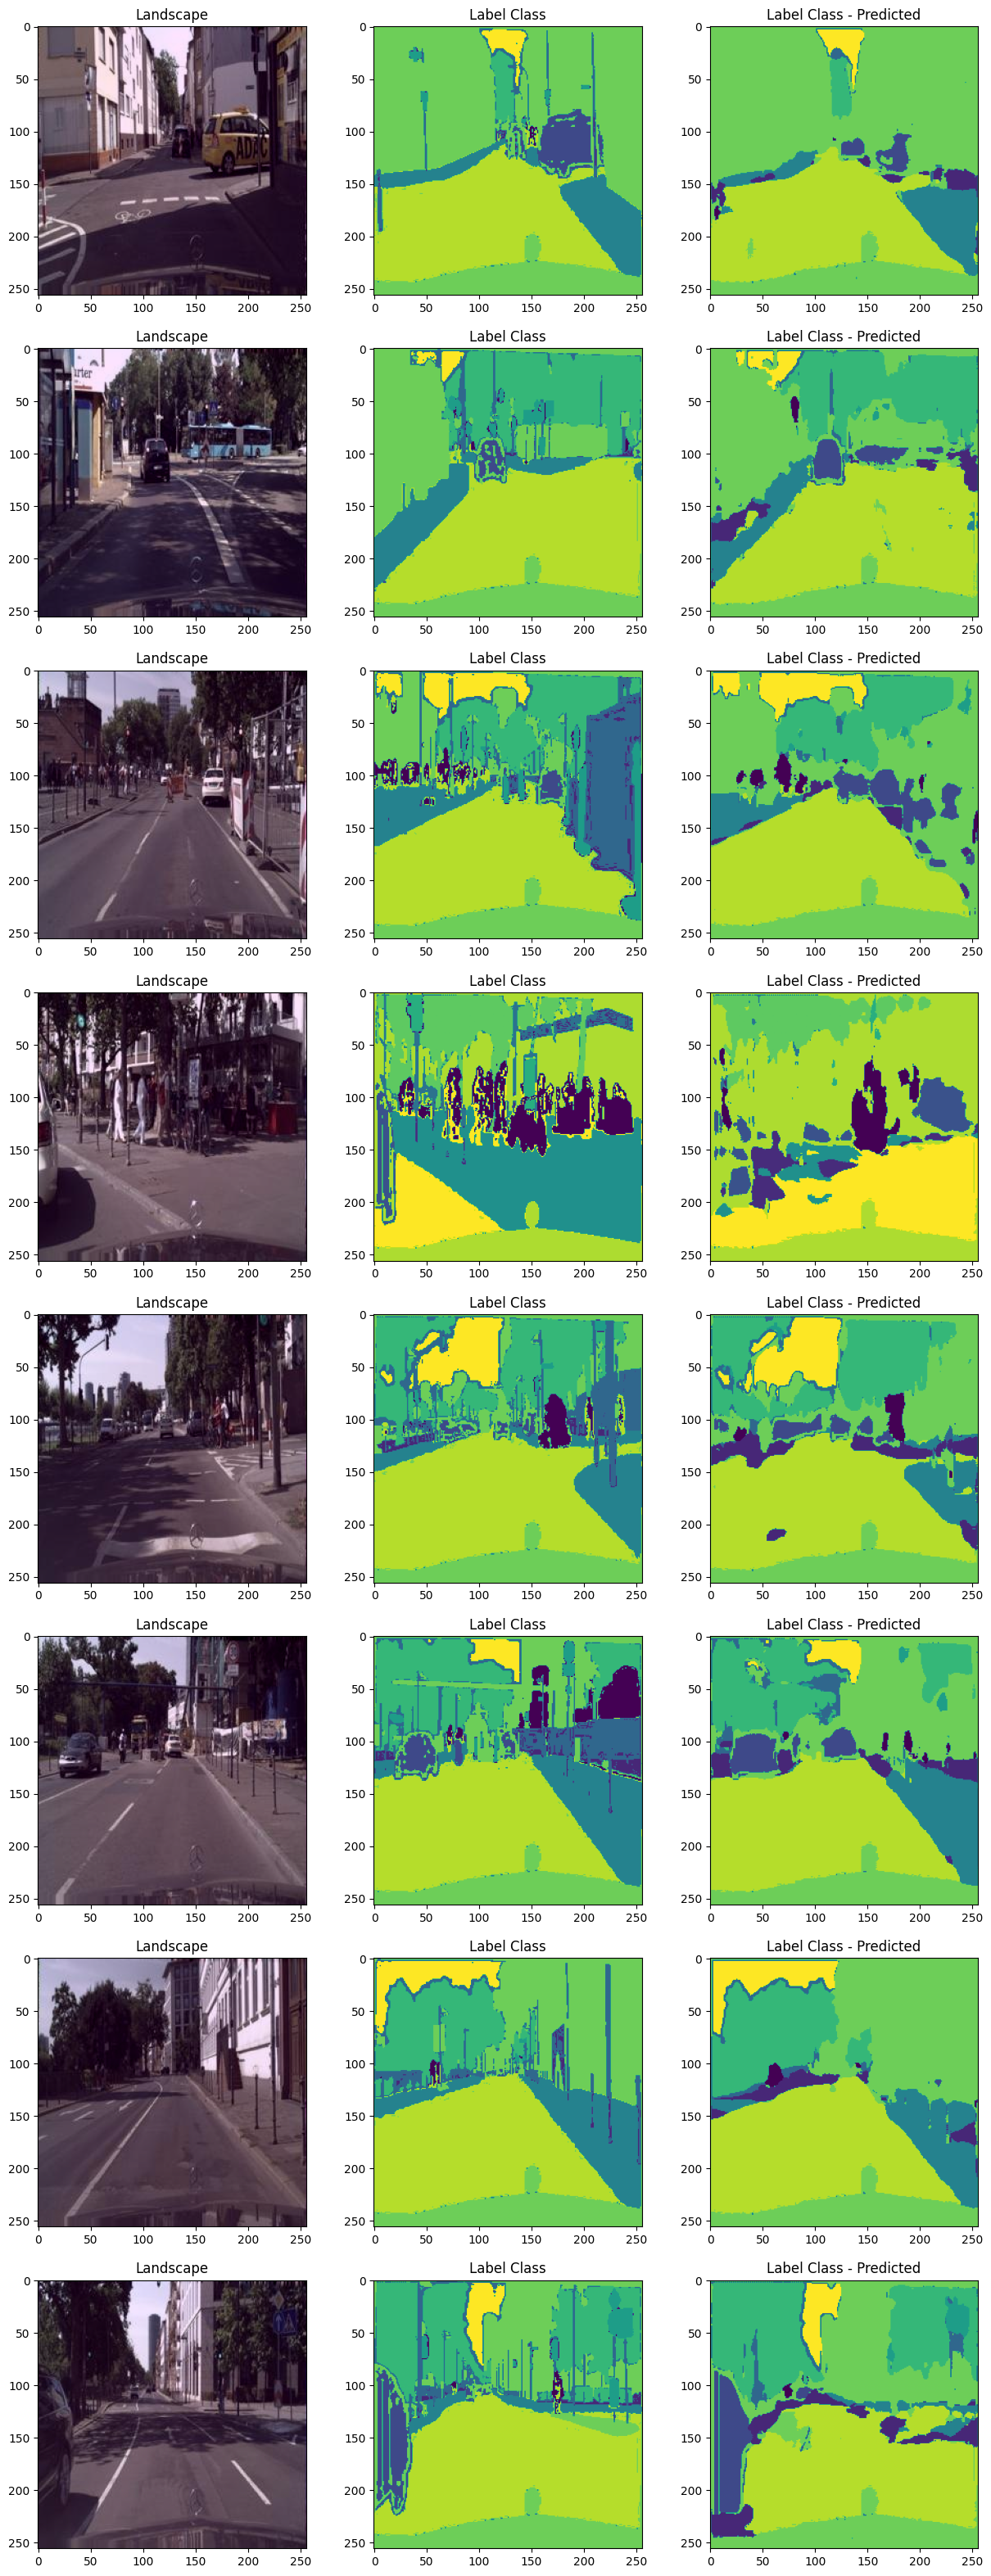

In [37]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

# **4. IoU Score**

In [38]:
##TODO
print(np.mean(iou_scores))

0.9737090582310244
